In [27]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from pytorch_lightning import LightningDataModule
from pytorch_lightning import LightningModule
import torch
from torch import nn
import torch.nn.functional as F
from pytorch_lightning import Trainer
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
class MNISTData(LightningDataModule):
    def __init__(self, data_dir: str = './', batch_size: int = 64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = ToTensor()

    def setup(self, stage=None):
        # Loading the MNIST training dataset
        mnist_data = MNIST(root=self.data_dir, train=True, download=True, transform=self.transform)
        # Split the dataset into sub_train and valid sets
        self.mnist_train, self.mnist_valid = random_split(mnist_data, [50000, 10000])
        # Loading the MNIST test dataset
        self.mnist_test = MNIST(root=self.data_dir, train=False, download=True, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_valid, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)


In [29]:
mnist_data = MNISTData()
mnist_data.setup()

# sizes of the datasets
print(f"Training set size: {len(mnist_data.mnist_train)}")
print(f"Validation set size: {len(mnist_data.mnist_valid)}")


Training set size: 50000
Validation set size: 10000


In [30]:
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl

class MLP(pl.LightningModule):
    def __init__(self, input_dim=784, hidden_dims=[128, 64], output_dim=10, optimizer_choice='SGD', **optimizer_settings):
        super(MLP, self).__init__()
        self.save_hyperparameters()
        #architecture
        layers = [
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU()
        ]
        # Dynamically adding hidden layers
        for i in range(1, len(hidden_dims)):
            layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.model_layers = nn.Sequential(*layers)
        
    def forward(self, inputs):
        return self.model_layers(inputs)
    
    def training_step(self, batch_data, batch_idx):
        inputs, labels = batch_data
        predictions = self(inputs)
        loss = F.cross_entropy(predictions, labels)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch_data, batch_idx):
        inputs, labels = batch_data
        predictions = self(inputs)
        loss = F.cross_entropy(predictions, labels)
        accuracy = torch.mean((torch.argmax(predictions, dim=1) == labels).float())
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', accuracy, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': accuracy}
    
    def configure_optimizers(self):
        optimizers = {
            'SGD': torch.optim.SGD,
            'AdaGrad': torch.optim.Adagrad,
            'RMSProp': torch.optim.RMSprop,
            'Adam': torch.optim.Adam
        }
        if self.hparams.optimizer_choice in optimizers:
            optimizer = optimizers[self.hparams.optimizer_choice](self.parameters(), **self.hparams.optimizer_settings)
        else:
            raise ValueError(f"Unsupported optimizer: {self.hparams.optimizer_choice}")
        
        return optimizer


In [38]:
import torch
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train_network(model, train_data_loader, validation_data_loader, num_epochs=10, learning_rate=0.01, momentum_value=0.9, optimizer_type='SGD'):
    # Configured the optimizer based on the optimizer type
    optimizers = {
        'SGD': optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum_value),
        'AdaGrad': optim.Adagrad(model.parameters(), lr=learning_rate),
        'RMSProp': optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum_value),
        'Adam': optim.Adam(model.parameters(), lr=learning_rate)
    }
    optimizer = optimizers.get(optimizer_type)
    if not optimizer:
        raise ValueError(f'Optimizer "{optimizer_type}" is not supported.')
    training_losses, validation_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        total_training_loss = 0
        for inputs, targets in train_data_loader:
            optimizer.zero_grad()
            predictions = model(inputs)
            loss = F.cross_entropy(predictions, targets)
            loss.backward()
            optimizer.step()
            total_training_loss += loss.item()
        average_training_loss = total_training_loss / len(train_data_loader)
        training_losses.append(average_training_loss)

        model.eval()
        total_validation_loss = 0
        with torch.no_grad():
            for inputs, targets in validation_data_loader:
                predictions = model(inputs)
                loss = F.cross_entropy(predictions, targets)
                total_validation_loss += loss.item()
        average_validation_loss = total_validation_loss / len(validation_data_loader)
        validation_losses.append(average_validation_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {average_training_loss}, Validation Loss: {average_validation_loss}')
    return training_losses, validation_losses

In [39]:
mnist_dataset = MNISTData() 
mnist_dataset.setup() 

train_loader = mnist_dataset.train_dataloader()  
valid_loader = mnist_dataset.val_dataloader()  

network_model = MLP() 

Epoch 1/10, Training Loss: 0.5908509940385361, Validation Loss: 0.29285594536240694
Epoch 2/10, Training Loss: 0.21555958691593782, Validation Loss: 0.18178114202466739
Epoch 3/10, Training Loss: 0.149931003898144, Validation Loss: 0.14149119166337001
Epoch 4/10, Training Loss: 0.11342841774210943, Validation Loss: 0.1287351070078695
Epoch 5/10, Training Loss: 0.09000248308031512, Validation Loss: 0.11823706212008644
Epoch 6/10, Training Loss: 0.07434946740560634, Validation Loss: 0.10092927017812706
Epoch 7/10, Training Loss: 0.061941901272486735, Validation Loss: 0.09007808391989511
Epoch 8/10, Training Loss: 0.052124009318494945, Validation Loss: 0.08550541466517243
Epoch 9/10, Training Loss: 0.04456601698514875, Validation Loss: 0.08519202544336106
Epoch 10/10, Training Loss: 0.03847951726312689, Validation Loss: 0.08809225437984725


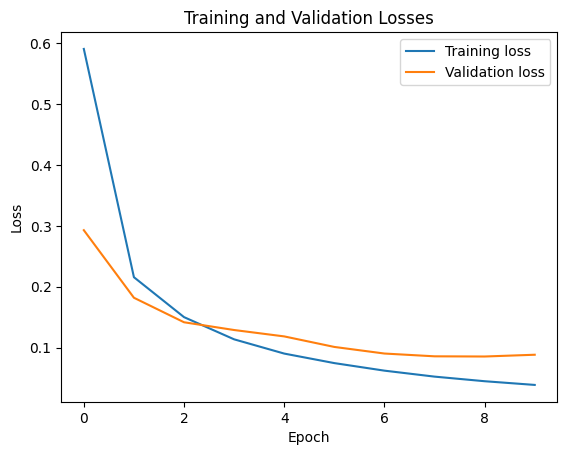

In [41]:
# Train the model
# SGD
train_losses_sgd, val_losses_sgd = train_network(network_model, train_loader, valid_loader, num_epochs=10, learning_rate=0.01, momentum_value=0.9, optimizer_type='SGD')

plt.plot(train_losses_sgd, label='Training loss')  
plt.plot(val_losses_sgd, label='Validation loss') 
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.legend()  
plt.title('Training and Validation Losses')  
plt.show()  

Epoch 1/10, Train Loss: 0.0590844713084464, Validation Loss: 0.08143374442781327
Epoch 2/10, Train Loss: 0.026242102233126112, Validation Loss: 0.07949215572944303
Epoch 3/10, Train Loss: 0.02019632019518215, Validation Loss: 0.0782662978882243
Epoch 4/10, Train Loss: 0.01725353236289938, Validation Loss: 0.08081353808142197
Epoch 5/10, Train Loss: 0.014749559672752424, Validation Loss: 0.0783746212729769
Epoch 6/10, Train Loss: 0.012868068754792695, Validation Loss: 0.07812314231399518
Epoch 7/10, Train Loss: 0.01136377651791941, Validation Loss: 0.07857712237965198
Epoch 8/10, Train Loss: 0.010230309409646155, Validation Loss: 0.07814277876850668
Epoch 9/10, Train Loss: 0.009195285694598628, Validation Loss: 0.07856813846096682
Epoch 10/10, Train Loss: 0.008296866161862503, Validation Loss: 0.08010078829885194


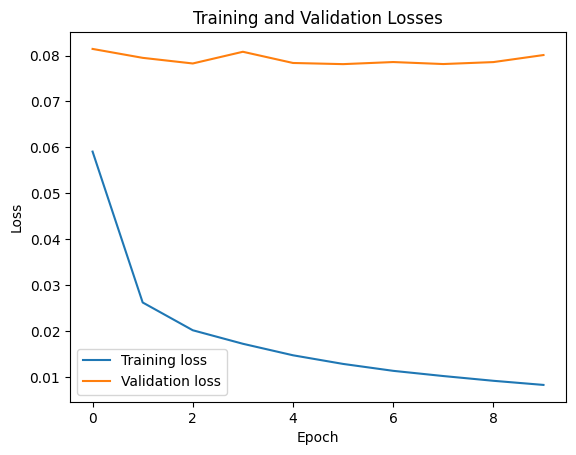

In [12]:
# AdaGrad
train_losses_adagrad, val_losses_adagrad = train_network(model, train_loader, valid_loader, num_epochs=10, learning_rate=0.01, optimizer_type='AdaGrad')
plt.plot(train_losses_adagrad, label='Training loss')  
plt.plot(val_losses_adagrad, label='Validation loss')  
plt.xlabel('Epoch') 
plt.ylabel('Loss')  
plt.legend() 
plt.title('Training and Validation Losses')  
plt.show() 

Epoch 1/10, Train Loss: 5.658634607082583, Validation Loss: 2.306928156287807
Epoch 2/10, Train Loss: 2.3095266136062116, Validation Loss: 2.3134202714178973
Epoch 3/10, Train Loss: 2.31077032564851, Validation Loss: 2.3093049161753076
Epoch 4/10, Train Loss: 2.3099102275755703, Validation Loss: 2.308904837650858
Epoch 5/10, Train Loss: 2.3099241832942914, Validation Loss: 2.30644566997601
Epoch 6/10, Train Loss: 2.3103815009222006, Validation Loss: 2.3100369918118617
Epoch 7/10, Train Loss: 2.3099632101595553, Validation Loss: 2.307915482551429
Epoch 8/10, Train Loss: 2.3097428491963146, Validation Loss: 2.3099421832212217
Epoch 9/10, Train Loss: 2.3106777988126517, Validation Loss: 2.311437403320507
Epoch 10/10, Train Loss: 2.309506529127545, Validation Loss: 2.3087936890353062


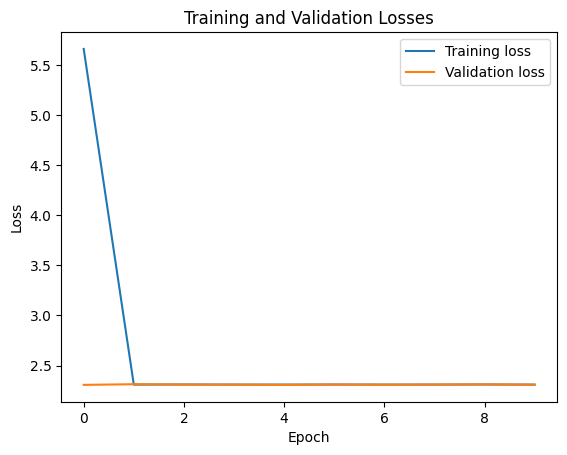

In [13]:
# RMSProp
train_losses_rmsprop, val_losses_rmsprop = train_network(model, train_loader, valid_loader, num_epochs=10, learning_rate=0.01, momentum_value=0.9, optimizer_type='RMSProp')

plt.plot(train_losses_rmsprop, label='Training loss')  
plt.plot(val_losses_rmsprop, label='Validation loss')  
plt.xlabel('Epoch') 
plt.ylabel('Loss')  
plt.legend() 
plt.title('Training and Validation Losses')  
plt.show() 

Epoch 1/10, Train Loss: 2.302437215509927, Validation Loss: 2.302468008296505
Epoch 2/10, Train Loss: 2.3018020489026823, Validation Loss: 2.3058469553661953
Epoch 3/10, Train Loss: 2.3020442794351017, Validation Loss: 2.30249421611713
Epoch 4/10, Train Loss: 2.302198955470034, Validation Loss: 2.3032020565810476
Epoch 5/10, Train Loss: 2.3021513348650138, Validation Loss: 2.3022533662759574
Epoch 6/10, Train Loss: 2.3020054486096666, Validation Loss: 2.3028111898215715
Epoch 7/10, Train Loss: 2.3020471319213245, Validation Loss: 2.3024776331178702
Epoch 8/10, Train Loss: 2.301975884705858, Validation Loss: 2.302650507847974
Epoch 9/10, Train Loss: 2.302143011861445, Validation Loss: 2.3030357497512917
Epoch 10/10, Train Loss: 2.302085704510779, Validation Loss: 2.3021972498316674


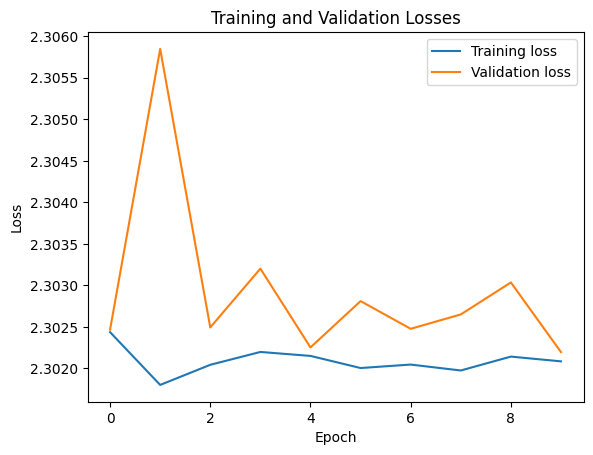

In [14]:
# Adam
train_losses_adam, val_losses_adam = train_network(model, train_loader, valid_loader, num_epochs=10, learning_rate=0.01, optimizer_type='Adam')

plt.plot(train_losses_adam, label='Training loss')  
plt.plot(val_losses_adam, label='Validation loss')  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.legend()  
plt.title('Training and Validation Losses')  
plt.show()  